# Setup 2: Cluster growth
Once we have defined how **single cells migrate** and **how the ECM influences their motility abilities**, we can finally start looking into **how tumor growth is affected by the density of the ECM**.

To do so, we will look into how cells seeded in different matrices grow and evolve through time. Particularly, we will be looking into the cell data to **classify the cells into clusters** and, subsquently, extract features such as their **area** and their **eccentricity**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
from scipy.spatial import distance as dist
from sklearn.cluster import DBSCAN
from matplotlib.patches import Ellipse

import physipy as phypy

%matplotlib inline

In [2]:
# Global variables
CELL_RADIUS = 8
VARIABLES = ['ID', 'position_x', 'position_y', 'position_z']
BASE_FOLDER = Path('../data/Final_550_72')                                                 

# Initial analysis: Cluster formation based on matrix density
## Reading output data
Our data consists of **3 different matrix density values**, which correspond to **collagen concentrations** of **2.5, 4.0 and 6.0 mg/mL**. For each of these conditions, we have **10 replicates**, and, for each replicate, we have **10 data points** (corresponding to 120 hours of simulation, captured at each 12 hours).

The data we want to extract from the output files corresponds to the **cell coordinates** at each timestep, as well as **the cells' IDs**, since we are dealing with a simulation of multiple cells. 

Given that, experimentally, we have concluded that cells seeded in matrices of low collagen concentration do not form clusters of considerable size, we will focus on the **medium and high densities**. Nonetheless, we will still look into the data for the lowest density, in order to confirm that the model captures the trends seen in the experiments.

Firstly, we can look into the cell distribution at a certain time point. To do this, we **draw each cell as a circle with the same radius as the simulated cells**. We do this to get a representation that is more geometrically accurate than that we would obtain from a standard scatter plot.

In [27]:
timestep = 5                                        
replicate = 2
initial_densities_values = [2.5, 4.0, 6.0]
initial_densities_folders = ['Low', 'Med', 'High'] 

cells_list = []

for density, density_value in zip(initial_densities_folders, initial_densities_values):
    # Extract cell data from output folders
    density_folder = BASE_FOLDER / '{}Density/'.format(density)
    replicate_folder = 'output{}/'.format(replicate)
    cells_folder = density_folder / replicate_folder
    cells = phypy.get_cell_data(timestep, cells_folder, VARIABLES)
    
    # Select only the variables values (not the labels)
    # Store the values alongside the density values and names
    for cell_index in range(len(cells['ID'])):
        cells_data = [cells[variable][cell_index] for variable in VARIABLES]
        settings_data = [density, density_value]
        cells_list_temp = cells_data + settings_data

        cells_list.append(cells_list_temp)

# List to DataFrame
cells_df = pd.DataFrame(cells_list, columns=['ID', 
                                             'position_x', 'position_y', 'position_z', 
                                             'density', 'col_concentration'])

# Print head of the DF
cells_df.head()

,ID,position_x,position_y,position_z,density,col_concentration
0,15.0,-400.000451,-2.334010,-12.665533,Low,2.5
1,1.0,-173.741489,-40.981570,-175.355339,Low,2.5
2,2.0,-222.355312,298.594396,42.726540,Low,2.5
3,73.0,-15.658258,-288.632279,-0.330158,Low,2.5
4,4.0,0.538914,-11.143554,-68.081055,Low,2.5


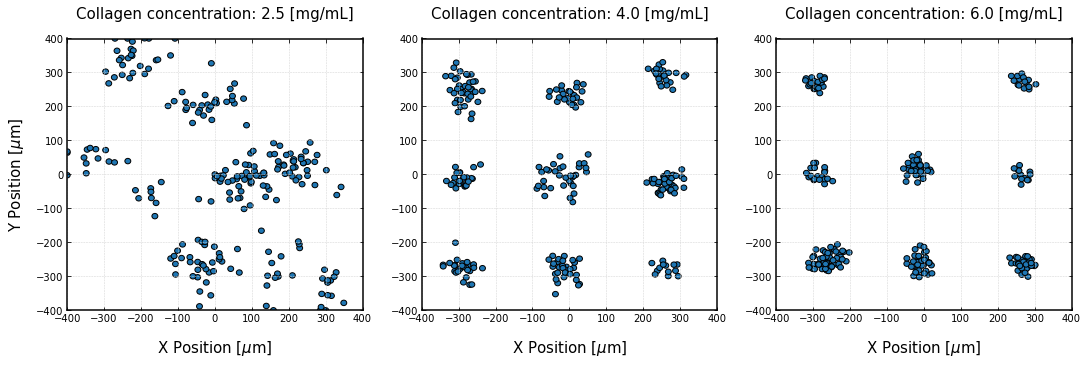

In [29]:
fig, axes = plt.subplots(1, len(initial_densities_folders), figsize=(18, 5))

for index, density in enumerate(initial_densities_folders):
    # Select ax
    ax = axes[index]
    # Select data points of interest
    cell_query = 'density == "{}"'.format(density)
    cells_plot = cells_df.query(cell_query)
    
    # Draw cells with a circular geometry 
    phypy.draw_cells_as_circles(cells_plot, ax)
    
    # Figure aesthetics
    phypy.set_cell_view_style_axes(ax)
    phypy.set_cell_view_labels(ax, index, initial_densities_values)

## Selecting cells in a defined area
To replicate the effect of **image-based quantification**, in which cells in different planes are neglected, we will remove the cells that are not in a defined area of interest. In this case, we will select cells with a z coordinate between -48 and 48 microns.

In [22]:
HEIGHT_OF_INTESREST = 48

# Select cells
cells_df = phypy.cells_in_area_of_interest(cells_df,
                                           coordinate='z', size=HEIGHT_OF_INTESREST)
cells_df.head()

,ID,position_x,position_y,position_z,density,col_concentration
0,15.0,-400.000451,-2.334010,-12.665533,Low,2.5
2,2.0,-222.355312,298.594396,42.726540,Low,2.5
3,73.0,-15.658258,-288.632279,-0.330158,Low,2.5
8,14.0,132.597575,4.342158,-24.277426,Low,2.5
10,10.0,270.392082,36.964570,20.975879,Low,2.5


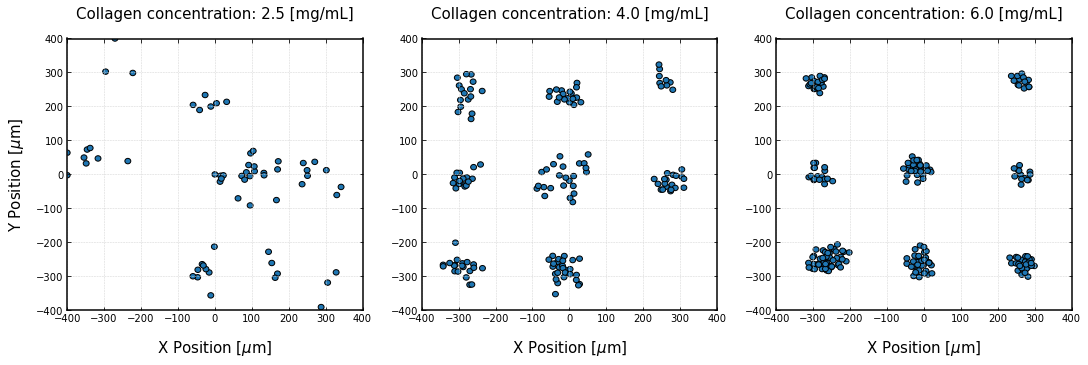

In [24]:
fig, axes = plt.subplots(1, len(initial_densities_folders), figsize=(18, 5))

for index, density in enumerate(initial_densities_folders):
    # Select ax
    ax = axes[index]
    # Select data points of interest
    cell_query = 'density == "{}"'.format(density)
    cells_plot = cells_df.query(cell_query)
    
    # Draw cells with a circular geometry 
    phypy.draw_cells_as_circles(cells_plot, ax)
    
    # Figure aesthetics
    phypy.set_cell_view_style_axes(ax)
    phypy.set_cell_view_labels(ax, index, initial_densities_values)

## Cluster Classification
Finally, we can classify each cell into a cluster, based on the distance to surrounding cells. To do so, we will be using the `DBSCAN` algorithm from `sklearn`, which requires us to select a radius of interaction and the minimum number of cells in a cluster.

Cells that do not belong to any of the clusters will be regarded as outliers.

In [7]:
DBSCAN_RADIUS = 18
DBSCAN_min_cells = 2
cells_df['cluster'] = 0

for density in densities_folders:
    # Select data points of interest
    cell_query = 'density == "{}"'.format(density)
    cell_indexes = cells_df.query(cell_query).index.to_list()

    # Classify cells based on spatial information
    cells_positions = cells_df.loc[cell_indexes][['position_x', 'position_y']]
    dbscan_clusters = DBSCAN(eps=DBSCAN_RADIUS, min_samples=DBSCAN_min_cells).fit(cells_positions)

    # Update the cells DataFrame with the corresponding cluster labels
    cells_df.at[cell_indexes, 'cluster'] = dbscan_clusters.labels_
    
cells_df.head()

,ID,position_x,position_y,position_z,density,col_concentration,cluster
0,15.0,-400.000451,-2.334010,-12.665533,Low,2.5,-1
2,2.0,-222.355312,298.594396,42.726540,Low,2.5,-1
3,73.0,-15.658258,-288.632279,-0.330158,Low,2.5,0
8,14.0,132.597575,4.342158,-24.277426,Low,2.5,1
10,10.0,270.392082,36.964570,20.975879,Low,2.5,-1


Having classified cells into clusters using **DBSCAN**, we assign a color to each of the clusters. Black cells represent cells that do not belong to any of the existing clusters. With this approach, we can clearly identify the multicellular clusters and study their shape and size. We conclude that matrices of low collagen density promote sparser cell distributions, whereas high density cells lead to the formation of large multicellular clusters.

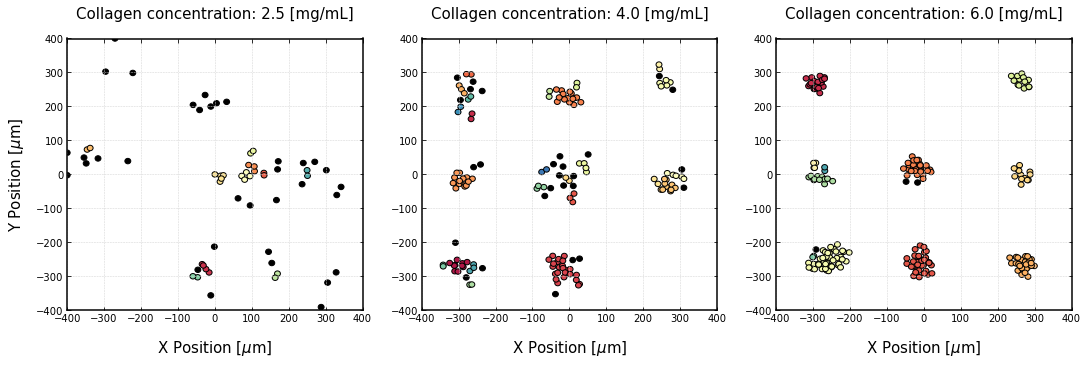

In [12]:
# Create fig object
fig, axes = plt.subplots(1,3)
fig.set_figwidth(18)
fig.set_figheight(5)

for index, density in enumerate(densities_folders):
    # Select ax
    ax = axes[index]
    # Select data points of interest
    cell_query = 'density == "{}"'.format(density)
    cluster_cells_plot = cells_df.query(cell_query)
    
    # Plot cells with an accurate representation of the assumed geometry
    # Create a palette with a number of colors equal to the number of clusters
    num_colors = len(cluster_cells_plot['cluster'].unique())
    my_palette = sns.color_palette('Spectral', num_colors)
    # Insert black into the first position of the palette for single cells
    my_palette.insert(len(my_palette), (0, 0, 0))
    
    # Draw cells as circles
    for x_pos, y_pos, color in zip(cells_to_plot['position_x'], cells_to_plot['position_y'], 
                                   cells_to_plot['cluster']):
        cell_contour = plt.Circle((x_pos, y_pos),
                                  CELL_RADIUS,
                                  facecolor=my_palette[color], edgecolor='black')

        ax.add_patch(cell_contour)
    
    # Figure aesthetics
    phypy.set_cell_view_style_axes(ax)
    phypy.set_cell_view_labels(ax, index, densities_values)

# Computing Cluster Areas
## Reading data
For a more quantitative analysis of the cluster features, we can compute **their areas** at each timepoint. 

To achieve this, we first classify the cells into clusters and disregard those that are classified as outliers. Subsequently, the **center of each cluster** is computed (as the average of the coordinates of cells that belong to said cluster), and the **distance of each cluster to this point** is also calculated. Finally, the **mean distance** is used to get the **radius of the cluster**, with which we can obtain its area, assuming a circular geometry.

In [30]:
number_of_replicates = 10
area_timesteps = [1, 3, 5]
densities_values = [4.0, 6.0]
densities_folders = ['Med', 'High'] 

area_cells_list = []

for density, density_value in zip(densities_folders, densities_values):
    for replicate in range(1, number_of_replicates + 1):
        for timestep in area_timesteps:
            # Extract data from output folder
            folder_name = BASE_FOLDER / '{}Density/output{}/'.format(density, str(replicate))
            cells = phypy.get_cell_data(timestep, folder_name, VARIABLES)
            
            for cell_index in range(len(cells['ID'])):
                cells_data = [cells[variable][cell_index] for variable in VARIABLES]
                settings_data = [timestep, replicate, density, density_value]
                cells_list_temp = cells_data + settings_data

                area_cells_list.append(cells_list_temp)

# List to DataFrame
area_cells_df = pd.DataFrame(area_cells_list, columns=['ID', 
                                                       'position_x', 'position_y', 'position_z', 
                                                       'timestep', 'replicate',
                                                       'density', 'col_concentration'])

# Select cells in the area of interest
area_cells_df = phypy.cells_in_area_of_interest(area_cells_df, 
                                                coordinate='z', size=HEIGHT_OF_INTESREST)

# Print initial lines of the DataFrame
area_cells_df.head()

,ID,position_x,position_y,position_z,timestep,replicate,density,col_concentration
0,0.0,-259.438115,-276.794838,-5.848285,1,1,Med,4.0
1,1.0,-291.610384,-11.163139,-24.516567,1,1,Med,4.0
2,2.0,-254.095940,270.169299,-2.643768,1,1,Med,4.0
3,3.0,-1.686236,-263.384739,10.759993,1,1,Med,4.0
4,4.0,3.638679,-1.003365,-7.232771,1,1,Med,4.0


## Cluster classification
We will use the same approach as before to classify cells into clusters.

In [33]:
clustered_cells_df = area_cells_df.copy()
clustered_cells_df['cluster'] = np.nan

for density, density_value in zip(densities_folders, densities_values):
    for replicate in range(1, number_of_replicates + 1):
        for timestep in timesteps:
            if timestep == 1:
                DBSCAN_min_cells = 2
            else:
                DBSCAN_min_cells = 3
                
            # Select data points of interest
            query = 'density == "{}" & replicate == {} & timestep == {}'
            cell_query = query.format(density, str(replicate), str(timestep))
            cell_indexes = clustered_cells_df.query(cell_query).index.to_list()

            # Classify cells based on spatial information
            cells_positions = clustered_cells_df.loc[cell_indexes][['position_x', 'position_y']]
            dbscan_clusters = DBSCAN(eps=DBSCAN_RADIUS, min_samples=DBSCAN_min_cells).fit(cells_positions)

            # Update the cells DataFrame with the corresponding cluster labels
            clustered_cells_df.loc[cell_indexes, 'cluster'] = dbscan_clusters.labels_
            
clustered_cells_df.head()

,ID,position_x,position_y,position_z,timestep,replicate,density,col_concentration,cluster
0,0.0,-259.438115,-276.794838,-5.848285,1,1,Med,4.0,0.0
1,1.0,-291.610384,-11.163139,-24.516567,1,1,Med,4.0,-1.0
2,2.0,-254.095940,270.169299,-2.643768,1,1,Med,4.0,1.0
3,3.0,-1.686236,-263.384739,10.759993,1,1,Med,4.0,-1.0
4,4.0,3.638679,-1.003365,-7.232771,1,1,Med,4.0,2.0


## Computing cluster metrics
To get a quantitative evaluation of the cluster sizes, we need to compute the **area of each cluster**. Thus, we will assume a **circular geometry** and calculate the radius of the clusters.

Firstly, we will identify the **centroid position** of the cluster by computing the average value of the x and y coordinates of the cells by which the cluster is composed. Subsequently, we can compute the **distance of each cell to this point**.

Using this data, we define that the cluster radius is given by the **average distance of the cells to the cluster centroid**, and we use this value to compute the area of the cluster. All of the area values are stored in a new DataFrame.

In [36]:
cluster_list = []
clustered_cells_df['distance_to_centroid'] = np.nan

for density, density_value in zip(densities_folders, densities_values):
    for replicate in range(1, number_of_replicates + 1):
        for timestep in timesteps:
            # Select data points of interest
            query = 'density == "{}" & replicate == {} & timestep == {}'
            cell_query = query.format(density, str(replicate), str(timestep))
            cell_indexes = clustered_cells_df.query(cell_query).index.to_list()
            
            # Loop through each cluster
            clusters = np.unique(clustered_cells_df.loc[cell_indexes, 'cluster'])
            
            for cluster in clusters:
                # Select cells in cluster
                cluster_query = cell_query + ' & cluster == {}'.format(cluster)
                cluster_indexes = clustered_cells_df.query(cluster_query).index.to_list()
                cluster_cells = clustered_cells_df.loc[cluster_indexes]
                # Get average cluster metrics (coordinates of centre position)
                cluster_data = cluster_cells.groupby('cluster').mean()
                
                # Exclude cells that do not belong to the clusters
                if cluster != -1:
                    cluster_x = cluster_data['position_x'].values[0]
                    cluster_y = cluster_data['position_y'].values[0]
                    centroid_position = (cluster_x, cluster_y)
                    
                    for cluster_index in cluster_indexes:
                        # Get cell position
                        cell_x_position = clustered_cells_df.loc[cluster_index]['position_x']
                        cell_y_position = clustered_cells_df.loc[cluster_index]['position_y']
                        cell_position = (cell_x_position, cell_y_position)

                        # Compute Euclidian distance between the cell and the centroid
                        distance = dist.euclidean(cell_position, centroid_position)

                        # Store distance
                        clustered_cells_df.at[cluster_index, 'distance_to_centroid'] = distance
                    
                    # Get average distance to the centroid, to use it as cluster radius
                    distances_to_centroid = clustered_cells_df.loc[cluster_indexes]['distance_to_centroid']
                    mean_distance_to_centroid = distances_to_centroid.mean()
                    
                    # Compute cluster area, assuming a circular geometry
                    cluster_radius = mean_distance_to_centroid + CELL_RADIUS
                    cluster_area = cluster_radius**2 * np.pi
                    
                    # Store data
                    cluster_metrics = [density_value, replicate, timestep,
                                       cluster, cluster_x, cluster_y, 
                                       mean_distance_to_centroid, cluster_radius, cluster_area]

                    cluster_list.append(cluster_metrics)


# List to DataFrame             
cluster_df = pd.DataFrame(cluster_list, columns=['collagen_concentration','replicate', 'days', 
                                                 'id', 'centroid_x', 'centroid_y', 
                                                 'distance', 'radius', 'area'])

cluster_df.head()

,collagen_concentration,replicate,days,id,centroid_x,centroid_y,distance,radius,area
0,4.0,1,1,0.0,-265.646890,-276.345885,6.224985,14.224985,635.701893
1,4.0,1,1,1.0,-258.177640,277.853843,8.701292,16.701292,876.294401
2,4.0,1,1,2.0,6.731795,-6.935104,6.689760,14.689760,677.921292
3,4.0,1,1,3.0,18.455356,280.588387,2.067732,10.067732,318.429400
4,4.0,1,1,4.0,288.433853,253.829724,1.078218,9.078218,258.911357


By plotting the distribution of area values through time we can confirm that collagen matrices of high collagen density promote the formation of large clusters.

Text(0, 0.5, 'Cluster Area [$\\mu$m$^2$]')

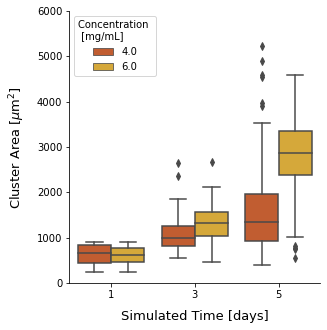

In [37]:
sns.set_palette(['#d95319', '#efb320'])
plt.figure(figsize=(4.5, 5))

sns.boxplot(data=cluster_df, x='days', y='area', hue='collagen_concentration')
sns.despine()
plt.legend(loc='upper left', title='Concentration \n [mg/mL]')
plt.ylim(0,6000)
plt.xlabel('Simulated Time [days]', labelpad=10, fontsize=13)
plt.ylabel('Cluster Area [$\mu$m$^2$]', labelpad=10, fontsize=13)

# Clusters Eccentricities
Lastly, we can get more information on the **shape of the clusters** by computing its **eccentricity**. This metric tells us the "roundness" of the cluster: low values of eccentricity correspond to clusters that are very close to a circle, whereas high values correspond to clusters that resemble a straight line.

Let's first process the data for day 7 using the same methods as before

## Reading data

In [42]:
number_of_replicates = 10
timestep = 7
densities_values = [4.0, 6.0]
densities_folders = ['Med', 'High'] 
DBSCAN_min_cells = 3

cells_list = []

for density, density_value in zip(densities_folders, densities_values):
    for replicate in range(1, number_of_replicates + 1):
        # Extract data from output folder
        folder_name = BASE_FOLDER / '{}Density/output{}/'.format(density, str(replicate))
        cells = phypy.get_cell_data(timestep, folder_name, VARIABLES)

        for cell_index in range(len(cells['ID'])):
            cells_data = [cells[variable][cell_index] for variable in VARIABLES]
            settings_data = [timestep, replicate, density, density_value]
            cells_list_temp = cells_data + settings_data

            cells_list.append(cells_list_temp)

# List to DataFrame
ecc_cells_df = pd.DataFrame(cells_list, columns=['ID', 'position_x', 'position_y', 'position_z', 
                                             'timestep', 'replicate',
                                             'density', 'col_concentration'])

# Print initial lines of the DataFrame
cells_df.head()

,ID,position_x,position_y,position_z,density,col_concentration
0,15.0,-400.000451,-2.334010,-12.665533,Low,2.5
1,1.0,-173.741489,-40.981570,-175.355339,Low,2.5
2,2.0,-222.355312,298.594396,42.726540,Low,2.5
3,73.0,-15.658258,-288.632279,-0.330158,Low,2.5
4,4.0,0.538914,-11.143554,-68.081055,Low,2.5


## Cluster classification

In [53]:
ecc_clustered_cells_df = ecc_cells_df.copy()
ecc_clustered_cells_df['cluster'] = np.nan

for density, density_value in zip(densities_folders, densities_values):
    for replicate in range(1, number_of_replicates + 1):
        # Select data points of interest
        query = 'density == "{}" & replicate == {}'
        cell_query = query.format(density, str(replicate), str(timestep))
        cell_indexes = ecc_clustered_cells_df.query(cell_query).index.to_list()

        # Classify cells based on spatial information
        cells_positions = ecc_clustered_cells_df.loc[cell_indexes][['position_x', 'position_y']]
        dbscan_clusters = DBSCAN(eps=DBSCAN_RADIUS, min_samples=DBSCAN_min_cells).fit(cells_positions)

        # Update the cells DataFrame with the corresponding cluster labels
        ecc_clustered_cells_df.loc[cell_indexes, 'cluster'] = dbscan_clusters.labels_
            
ecc_clustered_cells_df.head()

,ID,position_x,position_y,position_z,timestep,replicate,density,col_concentration,cluster
0,324.0,64.604711,-11.174564,-39.876080,7,1,Med,4.0,0.0
1,1.0,-282.244204,25.070545,-28.065002,7,1,Med,4.0,1.0
2,2.0,-266.844040,286.072241,-14.691633,7,1,Med,4.0,2.0
3,3.0,-49.291530,-267.606697,32.947401,7,1,Med,4.0,3.0
4,91.0,252.722730,-328.499865,-15.049939,7,1,Med,4.0,4.0


## Computing cluster metrics

In [57]:
ecc_clustered_cells_df['distance_to_centroid'] = np.nan

for density, density_value in zip(densities_folders, densities_values):
    for replicate in range(1, number_of_replicates + 1):
        # Select data points of interest
        query = 'density == "{}" & replicate == {}'
        cell_query = query.format(density, str(replicate))
        cell_indexes = ecc_clustered_cells_df.query(cell_query).index.to_list()

        # Loop through each cluster
        clusters = np.unique(ecc_clustered_cells_df.loc[cell_indexes, 'cluster'])
        
        for cluster in clusters:
            # Select cells in cluster
            cluster_query = cell_query + ' & cluster == {}'.format(cluster)
            cluster_indexes = ecc_clustered_cells_df.query(cluster_query).index.to_list()
            cluster_cells = ecc_clustered_cells_df.loc[cluster_indexes]
            # Get average cluster metrics (coordinates of centre position)
            cluster_data = cluster_cells.groupby('cluster').mean()

            # Exclude cells that do not belong to clusters
            if cluster != -1:
                cluster_x = cluster_data['position_x'].values[0]
                cluster_y = cluster_data['position_y'].values[0]
                centroid_position = (cluster_x, cluster_y)

                for cluster_index in cluster_indexes:
                    # Get cell position
                    cell_x_position = ecc_clustered_cells_df.loc[cluster_index]['position_x']
                    cell_y_position = ecc_clustered_cells_df.loc[cluster_index]['position_y']
                    cell_position = (cell_x_position, cell_y_position)

                    # Compute Euclidian distance between the cell and the centroid
                    distance = dist.euclidean(cell_position, centroid_position)

                    # Store distance
                    ecc_clustered_cells_df.at[cluster_index, 'distance_to_centroid'] = distance
                    
ecc_clustered_cells_df.head()

,ID,position_x,position_y,position_z,timestep,replicate,density,col_concentration,cluster,distance_to_centroid
0,324.0,64.604711,-11.174564,-39.876080,7,1,Med,4.0,0.0,46.883020
1,1.0,-282.244204,25.070545,-28.065002,7,1,Med,4.0,1.0,45.735353
2,2.0,-266.844040,286.072241,-14.691633,7,1,Med,4.0,2.0,19.952245
3,3.0,-49.291530,-267.606697,32.947401,7,1,Med,4.0,3.0,74.003408
4,91.0,252.722730,-328.499865,-15.049939,7,1,Med,4.0,4.0,32.670560


## Computing cluster eccentricity
Now that we have the cells classified into clusters and we know the area of each cluster, in order to compute the cluster eccentricity we first need to find the equivalent ellipse of each cluster, which is done using the **second moment method.**

An implementation of this method for a set of coordinates, x and y, representative of the cells in a cluster is shown below.

In [47]:
def compute_equivalent_ellipse(coords):
    """Computes and returns the equivalent ellipse of a set of coordinates.
    
    Uses the second moment method. Based on
    https://github.com/joferkington/oost_paper_code/blob/master/error_ellipse.py
    
    Parameters
    ----------
    coords : NumPy array
        The coordinates of the cells inside a cluster.
    """
    
    # Compute covariance matrix
    covariance_matrix = np.cov(coords, rowvar=False)
    vals, vecs = np.linalg.eigh(covariance_matrix)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:,order]
    
    # Get ellipse angle
    rotation_degree = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    
    # Get ellipse dimensions
    ellipse_x, ellipse_y = np.sqrt(vals)
    
    # Get center of ellipse
    ellipse_center = coords.mean(axis=0)
    
    return ellipse_center, ellipse_x, ellipse_y, rotation_degree

Once we have this ellipse, calculating the eccentricity value can be computed using the ellipse width and height, through the equation

$ecc=\frac{\sqrt{width^2 - height^2}}{width}$

To visualize this process, let's first analyze a single replicate, plotting the cells' positions, their equivalent ellipse and the corresponding eccentricity value.

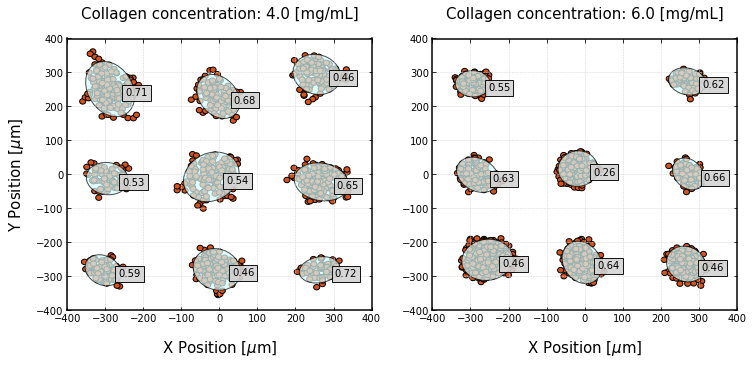

In [58]:
cells_to_plot = ecc_clustered_cells_df.copy()
replicate = 2
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for index, density in enumerate(densities_folders):
    ax = axes[index]
    # Select data points of interest
    query = 'density == "{}" & replicate == {}'
    cell_query = query.format(density, str(replicate))
    cell_indexes = cells_to_plot.query(cell_query).index.to_list()

    # Loop through each cluster
    clusters = np.unique(cells_to_plot.loc[cell_indexes, 'cluster'])

    for cluster in clusters:
        cluster_query = cell_query + ' & cluster == {}'.format(cluster)
        cluster_indexes = cells_to_plot.query(cluster_query).index.to_list()
        
        # Compute cluster area
        distances_to_centroid = cells_to_plot.loc[cluster_indexes]['distance_to_centroid']
        mean_distance_to_centroid = distances_to_centroid.mean()
        cluster_radius = mean_distance_to_centroid + CELL_RADIUS
        cluster_area = cluster_radius**2 * np.pi

        # Avoid selecting small structures (simulate manual selection)
        if cluster_area > 2300:
            cluster_position_x = cells_to_plot.loc[cluster_indexes]['position_x']
            cluster_position_y = cells_to_plot.loc[cluster_indexes]['position_y']

            # Compute equivalent ellipse (using the second moment method)
            # Format spatial data
            coords = [(x,y) for x, y in zip(cluster_position_x, cluster_position_y)]
            coords = np.array(coords)
            # Get ellipse metrics
            center_of_ellipse, ellipse_x, ellipse_y, rotation_angle = compute_equivalent_ellipse(coords)

            # Draw the equivalent ellipse
            # Scale the ellipse to fit the cluster
            number_standard_deviations = 2
            ellipse_artist = Ellipse(xy=center_of_ellipse, 
                                     width=2*number_standard_deviations*ellipse_x,
                                     height=2*number_standard_deviations*ellipse_y, 
                                     angle=rotation_angle,
                                     alpha=0.7, linewidth=1, facecolor='#D7FDFF', edgecolor='black')

            ax.add_artist(ellipse_artist)

            # Compute eccentricity of the ellipse
            eccentricity = np.sqrt(ellipse_x ** 2 - ellipse_y ** 2) / ellipse_x

            # Draw textboxes for each cluster, showcasing the respective eccentricity value
            text_box = dict(boxstyle='square', facecolor='lightgray', alpha=0.9, zorder=3)
            ax.text(cluster_position_x.mean()+40, cluster_position_y.mean()-20, 
                    str(round(eccentricity,2)), bbox=text_box)

        else:
            # Delete cells from clusters with areas smaller than 2300 microns^2
            cells_to_plot = cells_to_plot.drop(cluster_indexes)

    cells = cells_to_plot.query(cell_query)

    # Draw cells as circles
    phypy.draw_cells_as_circles(cells, ax)

    # Figure aesthetics
    phypy.set_cell_view_style_axes(ax)
    phypy.set_cell_view_labels(ax, index, densities_values)

## Cluster eccentricity stats
For a more quantitative analysis of this data, we can compute the cluster eccentricity for all replicates.

In [60]:
eccentricity_list = []

for density, density_value in zip(densities_folders, densities_values):
    for replicate in range(1, number_of_replicates + 1):
        # Select data points of interest
        query = 'density == "{}" & replicate == {}'
        cell_query = query.format(density, str(replicate))
        cell_indexes = clustered_cells_df.query(cell_query).index.to_list()

        # Loop through each cluster
        clusters = np.unique(clustered_cells_df.loc[cell_indexes, 'cluster'])
        
        for cluster in clusters:
            cluster_query = cell_query + ' & cluster == {}'.format(cluster)
            cluster_indexes = cells_to_plot.query(cluster_query).index.to_list()

            # Compute cluster area
            distances_to_centroid = cells_to_plot.loc[cluster_indexes]['distance_to_centroid']
            mean_distance_to_centroid = distances_to_centroid.mean()
            cluster_radius = mean_distance_to_centroid + CELL_RADIUS
            cluster_area = cluster_radius**2 * np.pi

            # Avoid selecting small structures (simulate manual selection)
            if cluster_area > 2300:
                cluster_position_x = cells_to_plot.loc[cluster_indexes]['position_x']
                cluster_position_y = cells_to_plot.loc[cluster_indexes]['position_y']

                # Compute equivalent ellipse (using the second moment method)
                # Format spatial data
                coords = [(x,y) for x, y in zip(cluster_position_x, cluster_position_y)]
                coords = np.array(coords)
                # Get ellipse metrics
                center_of_ellipse, ellipse_x, ellipse_y, rotation_angle = compute_equivalent_ellipse(coords)

                # Compute eccentricity of the ellipse
                eccentricity = np.sqrt(ellipse_x ** 2 - ellipse_y ** 2) / ellipse_x
                eccentricity_list.append([eccentricity, density_value])
                    
eccentricity_df = pd.DataFrame(eccentricity_list, columns=['eccentricity', 'collagen_concentration'])

eccentricity_df.head()

,eccentricity,collagen_concentration
0,0.295915,4.0
1,0.595845,4.0
2,0.804597,4.0
3,0.446478,4.0
4,0.439757,4.0


Text(0, 0.5, 'Eccentricity')

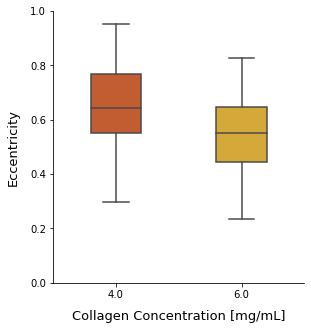

In [61]:
sns.set_palette(['#d95319', '#efb320'])
plt.figure(figsize=(4.5,5))
sns.boxplot(data=eccentricity_df, x='collagen_concentration', y='eccentricity', width=0.4)
sns.despine()
#plt.legend(loc='upper right', title='Concentration \n [mg/mL]')
plt.ylim(0,1)
plt.xlabel('Collagen Concentration [mg/mL]', labelpad=10, fontsize=13)
plt.ylabel('Eccentricity', labelpad=10, fontsize=13)